<a href="https://colab.research.google.com/github/shivangibithel/IRMiDis_Task2/blob/main/BERT_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Transformer and imports

In [ ]:
pip install transformers

In [4]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import math
import seaborn as sn
import tensorflow as tf
import tensorflow_datasets as tfds
from bs4 import BeautifulSoup
from sklearn import metrics as sk_metrics
import nltk
import re
from sklearn.utils import shuffle

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

# Data read and split...for some accuracy numbers

In [57]:
col_list = ["id", "tweet", "label"]
our_data = pd.read_csv("irmidis-2021-task2-train.csv",usecols=col_list)
df_test = pd.read_csv("irmidis-2021-task2-test.csv")
y_map = {
    'ProVax': 0, 
    'AntiVax': 1, 
    'Neutral': 2
}

our_data['Sentiment_Cat'] = our_data['label'].map(y_map)

In [58]:
our_data

,id,tweet,label,Sentiment_Cat
0,1325682517148569600,Coronavirus: Some Canadians hesitant to take a...,AntiVax,1
1,1325684180483600384,Moderna on track to report late-stage COVID-19...,Neutral,2
2,1325689685943996416,The Philippine government is in talks with Ang...,Neutral,2
3,1325690517724782593,Care homes to be FIRST to receive coronavirus ...,Neutral,2
4,1325697646909132800,This is why thinking that a vaccine is a panac...,AntiVax,1
...,...,...,...,...
2787,1325972470336278530,If a COVID-19 vaccine is effective it will be ...,Neutral,2
2788,1325770248382001152,"Pfizer claims coronavirus vaccine success, pla...",Neutral,2
2789,1325784714062409728,pump dat #COVID19 vaccine 💪😷🔥 https://t.co/Dna...,ProVax,0
2790,1325992175218417665,"LOL, not a chance I would get any vaccine let ...",AntiVax,1


In [59]:
df_test

,id,tweet
0,1259097719341297664,Polls Say Millions of Americans Will Refuse CO...
1,1307596484251062273,You are right. One should also remember that t...
2,1296241188823953409,So.... I should have got the keys to my new ho...
3,1294639481216045056,CDC - July 2020 ACIP Meeting - Overview of COV...
4,1319741954721239041,Notably absent is a vaccine for the nightmare ...
...,...,...
1595,1275394676594540547,🔓😷💉#VIDACov19: The ZOOM link for the Virual Me...
1596,1339072387363508224,@aakobel @EthanHovermale @dolmenlord @strictly...
1597,1328165880660955142,@charliekirk11 It's been 9 months since Covid ...
1598,1337209455986020353,Apparently the Covid 19 Vaccine caused bell’s ...


Uncomment if want testing results

In [60]:
from sklearn.model_selection import StratifiedShuffleSplit
df = our_data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_valid_index in split.split(df, df.Sentiment_Cat):
    train_set = df.iloc[train_index]
    test_valid_set = df.iloc[test_valid_index]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set.Sentiment_Cat):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]

print(train_set.shape)
print(test_valid_set.shape)
print(test_set.shape)
print(valid_set.shape)

df_train = train_set
df_test = test_set
df_valid = valid_set

(2233, 4)
(559, 4)
(279, 4)
(280, 4)


In [ ]:
df_train.info()

In [ ]:
df_train.Sentiment_Cat.value_counts()

In [ ]:
df_test.Sentiment_Cat.value_counts()

In [ ]:
df_train.head()

In [62]:
df_train['tweet'].iloc[0]

'It’s hard not to feel emotional. \n\nThis moment is a triumph for science, for human ingenuity, for Margaret, for our NHS workers, for the scared, and for hope. We are winning against #COVID19 with vaccines.\n\nThe end is in sight. https://t.co/c89R1qDQA8'

In [ ]:
# y_map = {
#     'ProVax': 0, 
#     'AntiVax': 1, 
#     'Neutral': 2
# }

# df_train['Sentiment_Cat'] = df_train['label'].map(y_map)
# df_test['Sentiment_Cat'] = df_test['label'].map(y_map)

# Pre-processing

In [14]:
import sys
import re
!pip install emoji --quiet
import emoji
!pip install contractions --quiet
import contractions
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import unicodedata

     |████████████████████████████████| 133kB 25.0MB/s 
     |████████████████████████████████| 327kB 35.3MB/s 
     |████████████████████████████████| 286kB 49.5MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def cleaning(text):
  text= text.lower()
  text= emoji.demojize(text)
  text=contractions.fix(text)
  text=text.strip()
  text=text.replace('[^\w\s]','')
  text=re.sub(r'http\S+', '', text)
  REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
  BAD_SYMBOLS_RE = re.compile('[^0-9a-z +]')
  text = REPLACE_BY_SPACE_RE.sub(' ' , text)
  text = BAD_SYMBOLS_RE.sub(' ',text)
  
  return text
df_train['tweet_cleaned'] = df_train['tweet'].apply(cleaning)
df_test['tweet_cleaned'] = df_test['tweet'].apply(cleaning)
df_valid['tweet_cleaned'] = df_valid['tweet'].apply(cleaning)
df_train['tweet_cleaned'].iloc[0]

In [64]:
x_train, y_train = df_train['tweet_cleaned'].values, np.array(df_train['Sentiment_Cat'], dtype=np.int64)
x_test, y_test = df_test['tweet_cleaned'].values, np.array(df_test['Sentiment_Cat'], dtype=np.int64)
x_valid, y_valid = df_valid['tweet_cleaned'].values, np.array(df_valid['Sentiment_Cat'], dtype=np.int64)

# Data Exploration

In [66]:
data = df_train
Neutral_data = data[data['Sentiment_Cat'] == 2]
Antivax_data = data[data['Sentiment_Cat'] == 1]
Provax_data = data[data['Sentiment_Cat'] == 0]

In [67]:
# df = Antivax_data
a=[]
for i in range(len(Antivax_data)):
  a.append(len(Antivax_data['tweet_cleaned'].iloc[i].split()))
print(max(a))
# df = Provax_data
b=[]
for i in range(len(Provax_data)):
  b.append(len(Provax_data['tweet_cleaned'].iloc[i].split()))
print(max(b))
# df = Neutral_data
c=[]
for i in range(len(Neutral_data)):
  c.append(len(Neutral_data['tweet_cleaned'].iloc[i].split()))
print(max(c))
print(len(Neutral_data), len(Antivax_data), len(Provax_data))

90
63
61
808 633 792


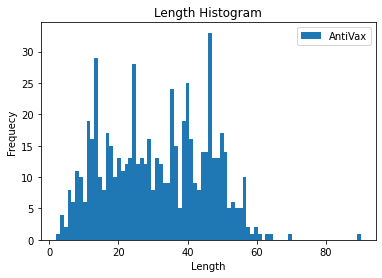

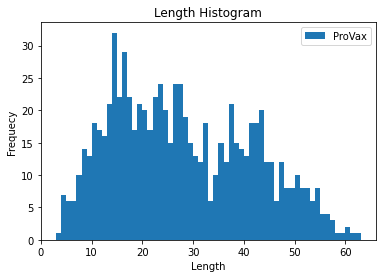

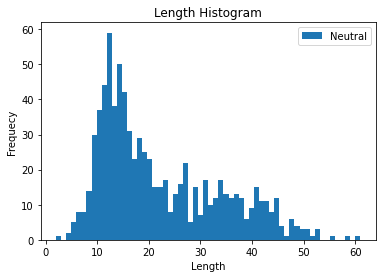

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import *
plt.hist(a,bins= 80, label = "AntiVax")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()
plt.hist(b,bins= 60, label = "ProVax")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()
plt.hist(c, bins= 60, label = "Neutral")
plt.legend()
plt.xlabel('Length')
plt.ylabel('Frequecy')
plt.title('Length Histogram')
plt.show()

# BERT

In [19]:
from tokenizers import BertWordPieceTokenizer
import transformers

In [20]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased', lower=True)

# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')

# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [21]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=200):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [69]:
max_len=70
x_train_enc = fast_encode(x_train, fast_tokenizer, maxlen=max_len)
x_valid_enc = fast_encode(x_valid, fast_tokenizer, maxlen=max_len)
x_test_enc = fast_encode(x_test, fast_tokenizer, maxlen=max_len)

In [ ]:
NUM_CLASSES = df_train['Sentiment_Cat'].nunique()

# bert_transformer = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')
# bert_transformer = transformers.TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_CLASSES)
bert_transformer = transformers.TFBertForSequenceClassification.from_pretrained('digitalepidemiologylab/covid-twitter-bert-v2', num_labels=NUM_CLASSES)
input = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32)
sequence_output = bert_transformer(input)[0]
# cls_token = sequence_output[:, 0, :]
# output = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(cls_token)

model = tf.keras.Model(inputs=input, outputs=sequence_output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [70]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
tf_bert_for_sequence_classif TFSequenceClassifierOutpu 335144963 
Total params: 335,144,963
Trainable params: 335,144,963
Non-trainable params: 0
_________________________________________________________________


In [71]:
# call backs
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True
)

history = model.fit(
    x_train_enc,
    y_train,
    batch_size=16,
    validation_data=(x_valid_enc, y_valid),
    epochs=50,
    callbacks=[early_stop_callback])

Epoch 1/50
140/140 [==============================] - 138s 790ms/step - loss: 0.8932 - accuracy: 0.5629 - val_loss: 0.6166 - val_accuracy: 0.7786
Epoch 2/50
140/140 [==============================] - 110s 786ms/step - loss: 0.5341 - accuracy: 0.8039 - val_loss: 0.4237 - val_accuracy: 0.8429
Epoch 3/50
140/140 [==============================] - 111s 795ms/step - loss: 0.3347 - accuracy: 0.8858 - val_loss: 0.4442 - val_accuracy: 0.8536
Epoch 4/50
140/140 [==============================] - 111s 794ms/step - loss: 0.2389 - accuracy: 0.9203 - val_loss: 0.3716 - val_accuracy: 0.8786
Epoch 5/50
140/140 [==============================] - 111s 795ms/step - loss: 0.1514 - accuracy: 0.9566 - val_loss: 0.3425 - val_accuracy: 0.8821
Epoch 6/50
140/140 [==============================] - 111s 796ms/step - loss: 0.0904 - accuracy: 0.9745 - val_loss: 0.4345 - val_accuracy: 0.8643
Epoch 7/50
140/140 [==============================] - 111s 793ms/step - loss: 0.0658 - accuracy: 0.9830 - val_loss: 0.4265 -

# Prediction 

In [74]:
ypred = model.predict(x_test_enc)
ypred
# df_test['ypred'] = np.argmax(ypred, axis=1)
# df_test['ypred_cat'] = np.where(df_test['ypred']>=0.5, 1, 0)
# df_test['ypred_cat'] = np.argmax(ypred, axis=1)
# df_test

array([[-1.3817313e+00,  2.5788240e+00, -1.6947902e+00],
       [-1.5651215e+00,  2.8601496e+00, -1.3311301e+00],
       [ 2.5417786e+00, -1.6946027e+00,  3.9803761e-01],
       [-5.3448850e-01,  1.9111959e-02,  1.3233504e+00],
       [ 4.2711277e+00, -2.3490660e+00, -1.4785558e+00],
       [-1.1871909e+00, -1.5215708e+00,  4.6882505e+00],
       [ 2.4736868e-01, -6.9644094e-02,  9.4269198e-01],
       [-4.6293804e-01, -2.0249534e+00,  3.8312099e+00],
       [-5.0490451e-01,  2.1712162e+00, -1.3278556e+00],
       [-1.4462025e+00,  2.9850941e+00, -1.4677289e+00],
       [ 4.8738045e-01, -7.9951805e-01,  2.3858795e+00],
       [-1.4449878e+00, -1.6248009e+00,  4.8306813e+00],
       [-8.7626302e-01, -1.9259299e+00,  3.8990610e+00],
       [ 4.1684594e+00, -1.7309027e+00, -1.4465849e+00],
       [-1.7719374e+00, -1.7755209e+00,  5.1474099e+00],
       [ 1.1256032e+00, -1.3513297e+00,  1.0778747e+00],
       [ 4.1251826e+00, -2.1534059e+00, -1.3222318e+00],
       [-1.1909922e+00,  2.3290

In [75]:
print(np.argmax(ypred, axis=1))

[1 1 0 2 0 2 2 2 1 1 2 2 2 0 2 0 0 1 1 1 2 2 2 0 0 2 1 0 2 2 1 0 2 0 2 1 0
 0 2 1 2 2 0 2 2 2 0 1 0 1 0 1 0 1 1 1 1 1 2 0 0 0 1 0 1 2 1 0 2 1 2 0 2 0
 2 1 1 2 2 1 0 2 0 0 2 2 0 0 1 0 0 1 0 2 2 0 2 1 0 2 1 2 0 2 2 1 0 0 0 2 2
 0 0 2 0 1 2 0 2 1 1 0 0 0 2 1 0 2 2 2 0 1 2 2 1 2 0 1 1 0 2 0 0 2 2 0 1 0
 0 2 2 2 2 0 2 1 1 2 2 1 2 0 0 0 1 2 2 1 0 0 2 2 0 1 1 1 0 1 0 2 2 1 2 0 2
 1 1 2 1 0 1 1 2 2 0 1 0 0 1 2 0 2 1 0 2 2 1 2 2 2 2 0 2 0 1 2 1 2 0 1 2 0
 1 0 1 0 1 0 0 1 1 0 1 1 0 0 2 2 0 1 1 1 1 1 1 0 2 1 2 2 0 0 0 2 1 0 2 2 2
 1 1 1 1 2 0 2 1 0 0 2 1 0 0 0 0 1 0 2 2]


In [76]:
df_test['ypred'] = np.argmax(ypred, axis=1)
df_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id,tweet,label,Sentiment_Cat,tweet_cleaned,ypred
1913,1325804701561008135,I am not 100% happy about the vaccine because ...,AntiVax,1,i am not 100 happy about the vaccine because ...,1
424,1325669230281326592,#PLANDEMIC2 \n\nWhat's in vaccines?\n\nDoes an...,AntiVax,1,plandemic2 what is in vaccines does anyon...,1
2282,1326107054549962752,Coronavirus Update \n\nThere has been a soarin...,ProVax,0,coronavirus update there has been a soaring ...,0
2504,1325770588451958786,"If made available by the end of the year, this...",ProVax,0,if made available by the end of the year this...,2
1264,1329097525140328448,"LETS GO. This is some great news, and it’s als...",ProVax,0,let us go this is some great news and it is ...,0
...,...,...,...,...,...,...
1399,1325864111708631040,"Good news finally, definitely worth reading 👍👍...",ProVax,0,good news finally definitely worth reading t...,0
2066,1325682016390705153,#Nazi #vaccine policies which #NurembergTrials...,AntiVax,1,nazi vaccine policies which nurembergtrials...,1
2073,1325770704072151040,Promising news in search for a Covid-19 vaccin...,ProVax,0,promising news in search for a covid 19 vaccine,0
2412,1325696659523657728,The bulk of vaccines against COVID-19 will be ...,Neutral,2,the bulk of vaccines against covid 19 will be ...,2


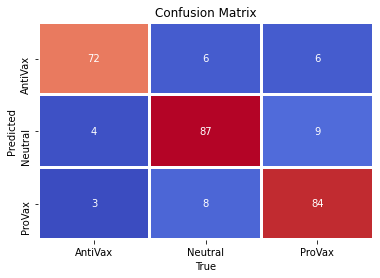

In [77]:
y_map_inv = {
    0: 'ProVax',
    1: 'AntiVax',
    2: 'Neutral'
}

# y_map = {
#     'ProVax': 0, 
#     'AntiVax': 1, 
#     'Neutral': 2
# }

sns.heatmap(
    pd.crosstab(df_test['ypred'].map(y_map_inv), df_test['Sentiment_Cat'].map(y_map_inv)),
    annot=True,
    fmt='0.0f',
    cbar=False,
    linewidth=2,
    cmap='coolwarm'     
)

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix');

In [78]:
y_test = df_test['Sentiment_Cat'].map(y_map_inv)
y_pred = df_test['ypred'].map(y_map_inv)
#importing confusion matrix
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3']))


Confusion Matrix

[[72  4  3]
 [ 6 87  8]
 [ 6  9 84]]

Accuracy: 0.87

Micro Precision: 0.87
Micro Recall: 0.87
Micro F1-score: 0.87

Macro Precision: 0.87
Macro Recall: 0.87
Macro F1-score: 0.87

Weighted Precision: 0.87
Weighted Recall: 0.87
Weighted F1-score: 0.87

Classification Report

              precision    recall  f1-score   support

     Class 1       0.86      0.91      0.88        79
     Class 2       0.87      0.86      0.87       101
     Class 3       0.88      0.85      0.87        99

    accuracy                           0.87       279
   macro avg       0.87      0.87      0.87       279
weighted avg       0.87      0.87      0.87       279

